# Titanic competition with Logistic Regression


## Objectives

*   Clean Dataset
*   Train a Model to predict survive Vs Unsurvive 


In [1]:
import pandas as pd
import pylab as pl
import numpy as np
from sklearn import preprocessing
%matplotlib inline 
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv", index_col='PassengerId')

### Become Famaliar with data 

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [4]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

## Data Cleaning

In [6]:
'''
    Let's fill Age with mean of Age columns and Embarked with mode of it (to better filling Embarked I think it is good first 
    we splite our dataset to Survived an Unsurvides and fill embarked on mode of relative)
'''
df_train['Age'].fillna(df_train['Age'].mean(), inplace=True)
df_train['Embarked'].fillna(df_train['Embarked'].mode()[0], inplace=True)


In [7]:
import random
def fill_cabin(cabin):
    cabins = []
    for c in list(df_train['Cabin'].mode()):
        cabins += c.split(" ")
    cabin = random.choice(cabins)
    return cabin
mask = df_train['Cabin'].isnull()
df_train.loc[mask, 'Cabin'] = df_train.loc[mask, 'Cabin'].apply(fill_cabin)

In [8]:
df_train.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64

In [9]:
cabin_mapping = { 'G6': 1700, 'T': 1800}
def get_dicemal(cabin):
    hex_number = cabin.split(" ")[0]
    if hex_number in cabin_mapping:
        return cabin_mapping.get(hex_number)
    return int(hex_number, 16)

df_train['Cabin'] = df_train['Cabin'].apply(get_dicemal)

In [10]:
# let's change Embarked characters to a number {C: 0, Q:1, S:2}
from sklearn.preprocessing import LabelEncoder
embark_label_encoder = LabelEncoder()
df_train['Embarked']= embark_label_encoder.fit_transform(df_train['Embarked'])
df_train['Embarked'].unique()

array([2, 0, 1])

In [11]:
# Delete Ticket and name of Passenger
df_train.drop(columns=['Ticket', 'Name'], inplace=True)

In [12]:
# change sex to number {male:1, female:0}
sex_label_encoder = LabelEncoder()
df_train['Sex'] = sex_label_encoder.fit_transform(df_train['Sex'])
df_train['Sex'].unique()

array([1, 0])

In [13]:
# As we can see our dataset looks good to a machile learning model(it's features are all numric)
# Let's splite the dataset features to independent(X) and dependent(Y)
import numpy as np
X = np.asarray(df_train[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]])
Y = np.asarray(df_train['Survived'])

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [15]:
X = scaler.fit(X).transform(X)

In [16]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.1, solver='liblinear') #solver can be {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}
LR.fit(X, Y)

LogisticRegression(C=0.1, solver='liblinear')

In [17]:
Y_pred = LR.predict(X)

In [18]:
# Let's try the jaccard index for accuracy evaluation. we can define jaccard as the size of the intersection divided by 
# the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly match with 
# the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.
from sklearn.metrics import jaccard_score
jaccard_score(Y, Y_pred, pos_label=0)

0.7237654320987654

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(Y, Y_pred, labels=[1,0]))

[[243  99]
 [ 80 469]]


Normalized confusion matrix
[[0.71 0.29]
 [0.15 0.85]]


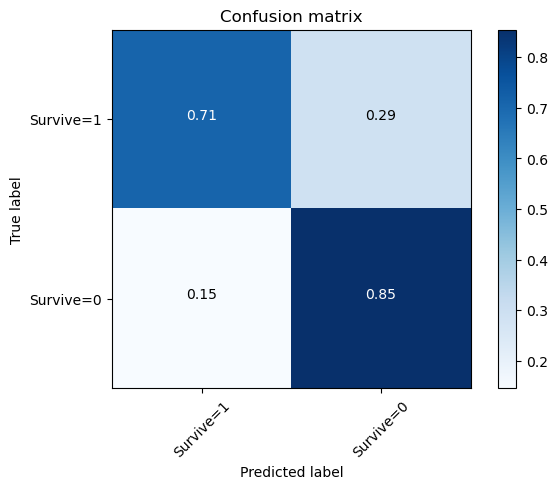

In [20]:
cnf_matrix = confusion_matrix(Y, Y_pred, labels=[1,0])
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Survive=1','Survive=0'],normalize= True,  title='Confusion matrix')

In [21]:
print (classification_report(Y, Y_pred))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       549
           1       0.75      0.71      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.79       891
weighted avg       0.80      0.80      0.80       891



**Precision** is a measure of the accuracy provided that a class label has been predicted. It is defined by: precision = TP / (TP + FP)

**Recall** is the true positive rate. It is defined as: Recall =  TP / (TP + FN)

So, we can calculate the precision and recall of each class.

**F1 score:** Now we are in the position to calculate the F1 scores for each label based on the precision and recall of that label.

In [22]:
from sklearn.metrics import log_loss
log_loss(Y, Y_pred)

7.241093105108832

In [23]:
df_test = pd.read_csv("/kaggle/input/titanic/test.csv", index_col='PassengerId')

In [24]:
df_test['Age'].fillna(df_test['Age'].mean(), inplace=True)

def fill_cabin(cabin):
    cabins = []
    for c in list(df_test['Cabin'].mode()):
        cabins += c.split(" ")
    cabin = random.choice(cabins)
    return cabin

def get_dicemal(cabin):
    hex_number = cabin.split(" ")[0]
    if hex_number in cabin_mapping:
        return cabin_mapping.get(hex_number)
    return int(hex_number, 16)


mask = df_test['Cabin'].isnull()
df_test.loc[mask, 'Cabin'] = df_test.loc[mask, 'Cabin'].apply(fill_cabin)

df_test['Cabin'] = df_test['Cabin'].apply(get_dicemal)



In [25]:
df_test['Embarked']= embark_label_encoder.fit_transform(df_test['Embarked'])


sex_label_encoder = LabelEncoder()
df_test['Sex'] = sex_label_encoder.fit_transform(df_test['Sex'])



In [26]:
df_test.drop(columns=['Ticket', 'Name'], inplace=True)

In [27]:
df_test['Fare'].fillna(35.627188489208635, inplace=True)

In [28]:
X = np.asarray(df_test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Cabin", "Embarked"]])
X = scaler.fit(X).transform(X)

In [29]:
Y_pred = LR.predict(X)

In [30]:
pred = pd.DataFrame(Y_pred, columns = ['Survived'])

In [31]:
ids = pd.DataFrame(df_test.index, columns = ['PassengerId'])

In [32]:
sub = pd.concat([ids, pred], axis=1)

In [33]:
sub.to_csv('submission.csv', index=False)